In [1]:
# Install catalax
# !pip install catalax

In [2]:
import numpy as np

import catalax as ctx
import catalax.mcmc as cmc

In [3]:
model = ctx.Model(name="Non-Observable Menten Inhibition")

# Another way of adding species (symbols and names at the same type)
model.add_species(
    s1="Substrate",
    e1="Enzyme",
)

# In this application 'e1' is not observable and thus
# 'k_d' needs to be inferred implicitly from the data.
model.add_ode("s1", "- e1 * k_cat * s1 / (s1 + K_m)")
model.add_ode("e1", "-k_d", observable=False)

model.parameters.K_m.value = 100.0
model.parameters.k_cat.value = 10.0
model.parameters.k_d.value = 0.0001

model

,name,symbol
0,Enzyme,e1
1,Substrate,s1


,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0000,False,None,None,None,None
1,k_cat,k_cat,10.0000,False,None,None,None,None
2,k_d,k_d,0.0001,False,None,None,None,None



Model(
    name='Non-Observable Menten Inhibition',
    odes=DottedDict({'s1': ODE(species=Species(name='Substrate', symbol=s1), equation=-e1*k_cat*s1/(K_m + s1), observable=True, parameters=DottedDict({'k_cat': Parameter(name='k_cat', symbol=k_cat, value=10.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, prior=None), 'K_m': Parameter(name='K_m', symbol=K_m, value=100.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, prior=None)})), 'e1': ODE(species=Species(name='Enzyme', symbol=e1), equation=-k_d, observable=False, parameters=DottedDict({'k_d': Parameter(name='k_d', symbol=k_d, value=0.0001, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, prior=None)}))}),
    species=,
    parameters=,
    term=None
)

In [4]:
# Create some dummy data to test
initial_conditions = [
    {"s1": 10.0, "e1": 0.1},
    {"s1": 50.0, "e1": 0.1},
    {"s1": 75.0, "e1": 0.1},
    {"s1": 100.0, "e1": 0.1},
    {"s1": 200.0, "e1": 0.1},
    {"s1": 300.0, "e1": 0.1},
    {"s1": 400.0, "e1": 0.1},
]

dataset = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1,
    t0=0,
    t1=1000,
    nsteps=10,
    in_axes=(0, None, None),
)

# Add some noise to the data, remove e1
for meas_id, meas in enumerate(dataset.measurements):
    for species_id, species in enumerate(meas.data.keys()):
        dataset.measurements[meas_id].data[species] = (
            meas.data[species] + meas.data[species] * np.random.normal(0, 0.02)
        ).clip(min=0)
    meas.data.pop("e1")


print(
    f"Time: {dataset.measurements[0].time.shape} | Data: {dataset.measurements[0].data['s1'].shape}"
)

Time: (10,) | Data: (10,)


/Users/max/Documents/GitHub/Catalax/catalax/dataset/dataset.py:551: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
/Users/max/Documents/GitHub/Catalax/catalax/dataset/dataset.py:558: UserWarning: The figure layout has changed to tight
  plt.tight_layout(w_pad=4, h_pad=4)


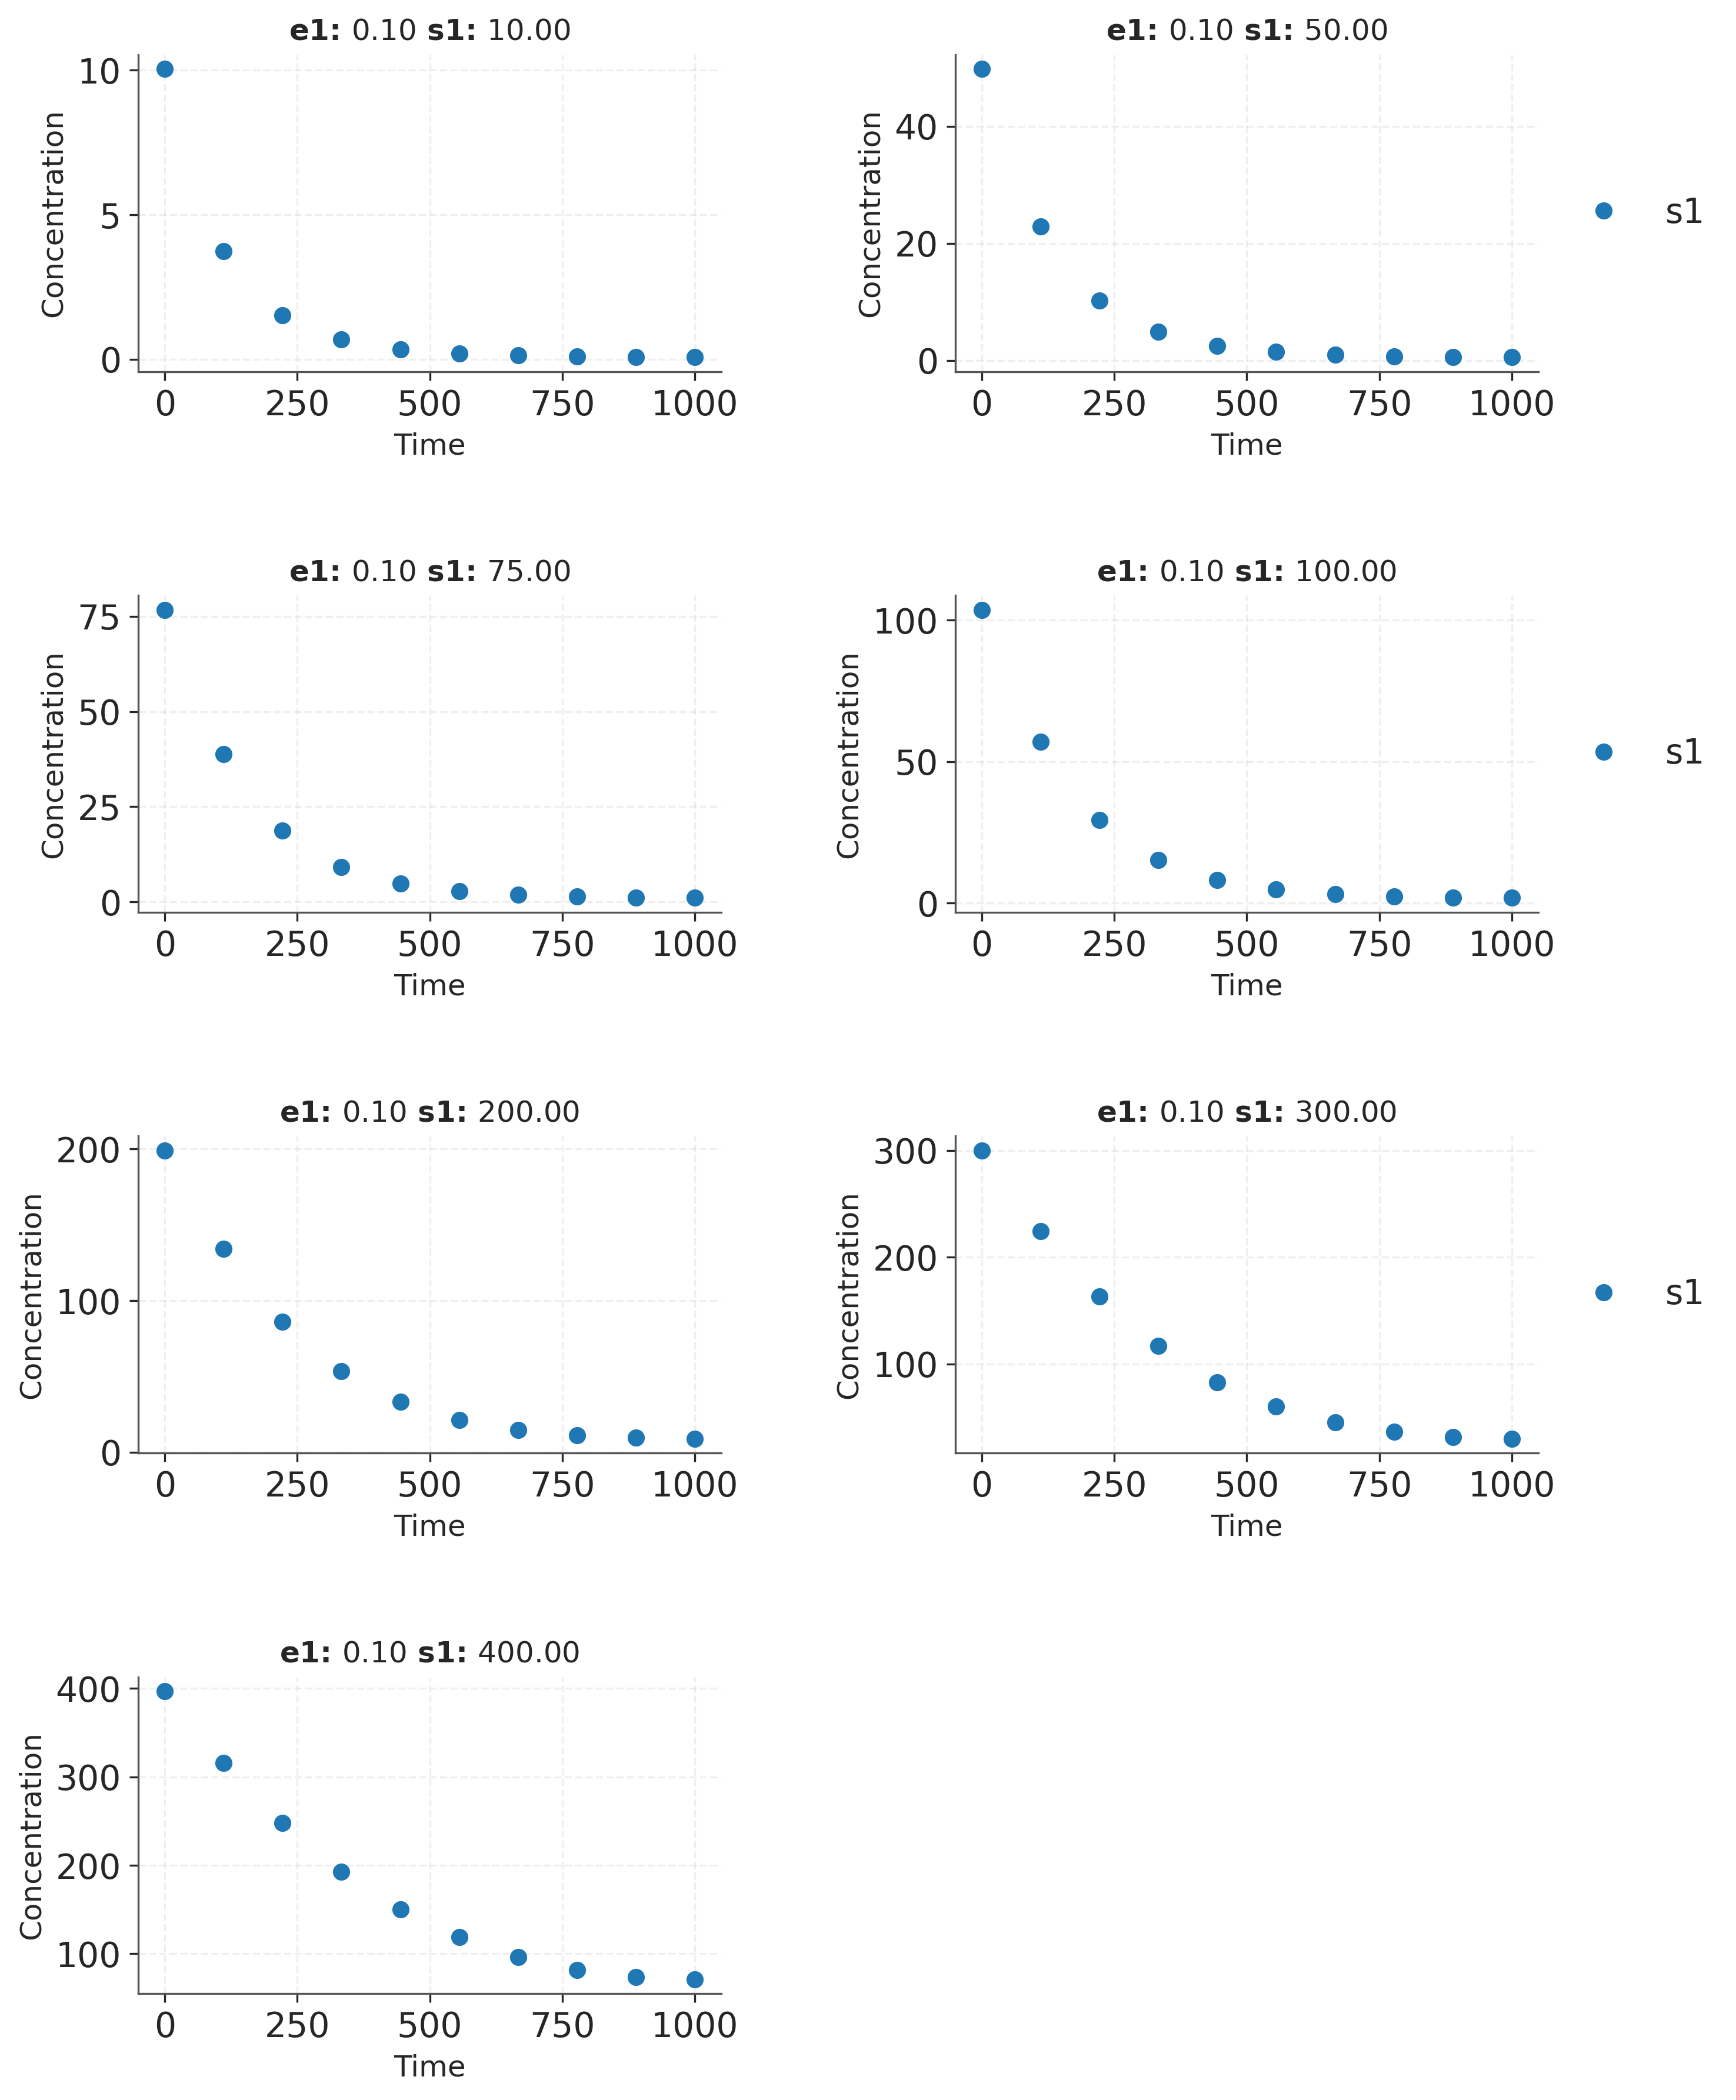

In [5]:
f = dataset.plot()


In [6]:
# Define Priors
model.parameters.k_cat.prior = cmc.priors.TruncatedNormal(
    mu=10.0, sigma=5.0, low=5.0, high=30.0
)
model.parameters.K_m.prior = cmc.priors.TruncatedNormal(
    mu=100.0, sigma=10.0, low=10.0, high=1000.0
)
model.parameters.k_d.prior = cmc.priors.Uniform(low=1e-5, high=9e-3)

mcmc, _ = cmc.run_mcmc(
    model=model,
    dataset=dataset,
    yerrs=0.97,
    num_warmup=1000,
    num_samples=1000,
    dt0=1.0,
    dense_mass=True,
    max_steps=63**4,
)



🚀 Running MCMC



sample: 100%|██████████| 2000/2000 [00:28<00:00, 69.00it/s, 7 steps of size 4.20e-01. acc. prob=0.93]  




🎉 Finished

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       K_m    103.98      1.17    103.96    101.99    105.75    526.19      1.00
     k_cat     10.18      0.04     10.18     10.11     10.24    503.99      1.00
       k_d      0.00      0.00      0.00      0.00      0.00    826.47      1.00
     sigma      0.76      0.06      0.76      0.66      0.87    553.33      1.00

Number of divergences: 0



array([<Axes: title={'center': 'K_m'}>, <Axes: title={'center': 'k_cat'}>,
       <Axes: title={'center': 'k_d'}>], dtype=object)

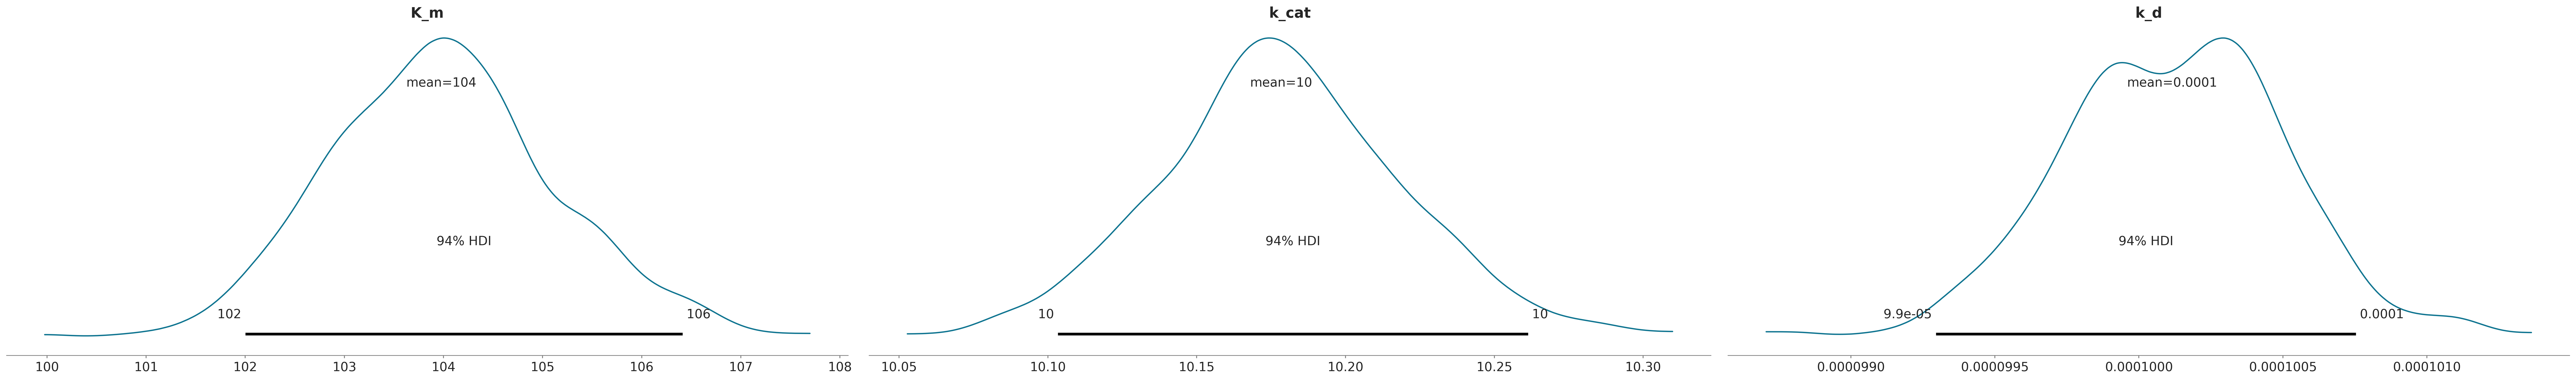

In [7]:
# Plot the posterior distributions
cmc.plot_posterior(mcmc, model)

/Users/max/miniconda3/envs/mha2025/lib/python3.12/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/Users/max/Documents/GitHub/Catalax/catalax/mcmc/plotting.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


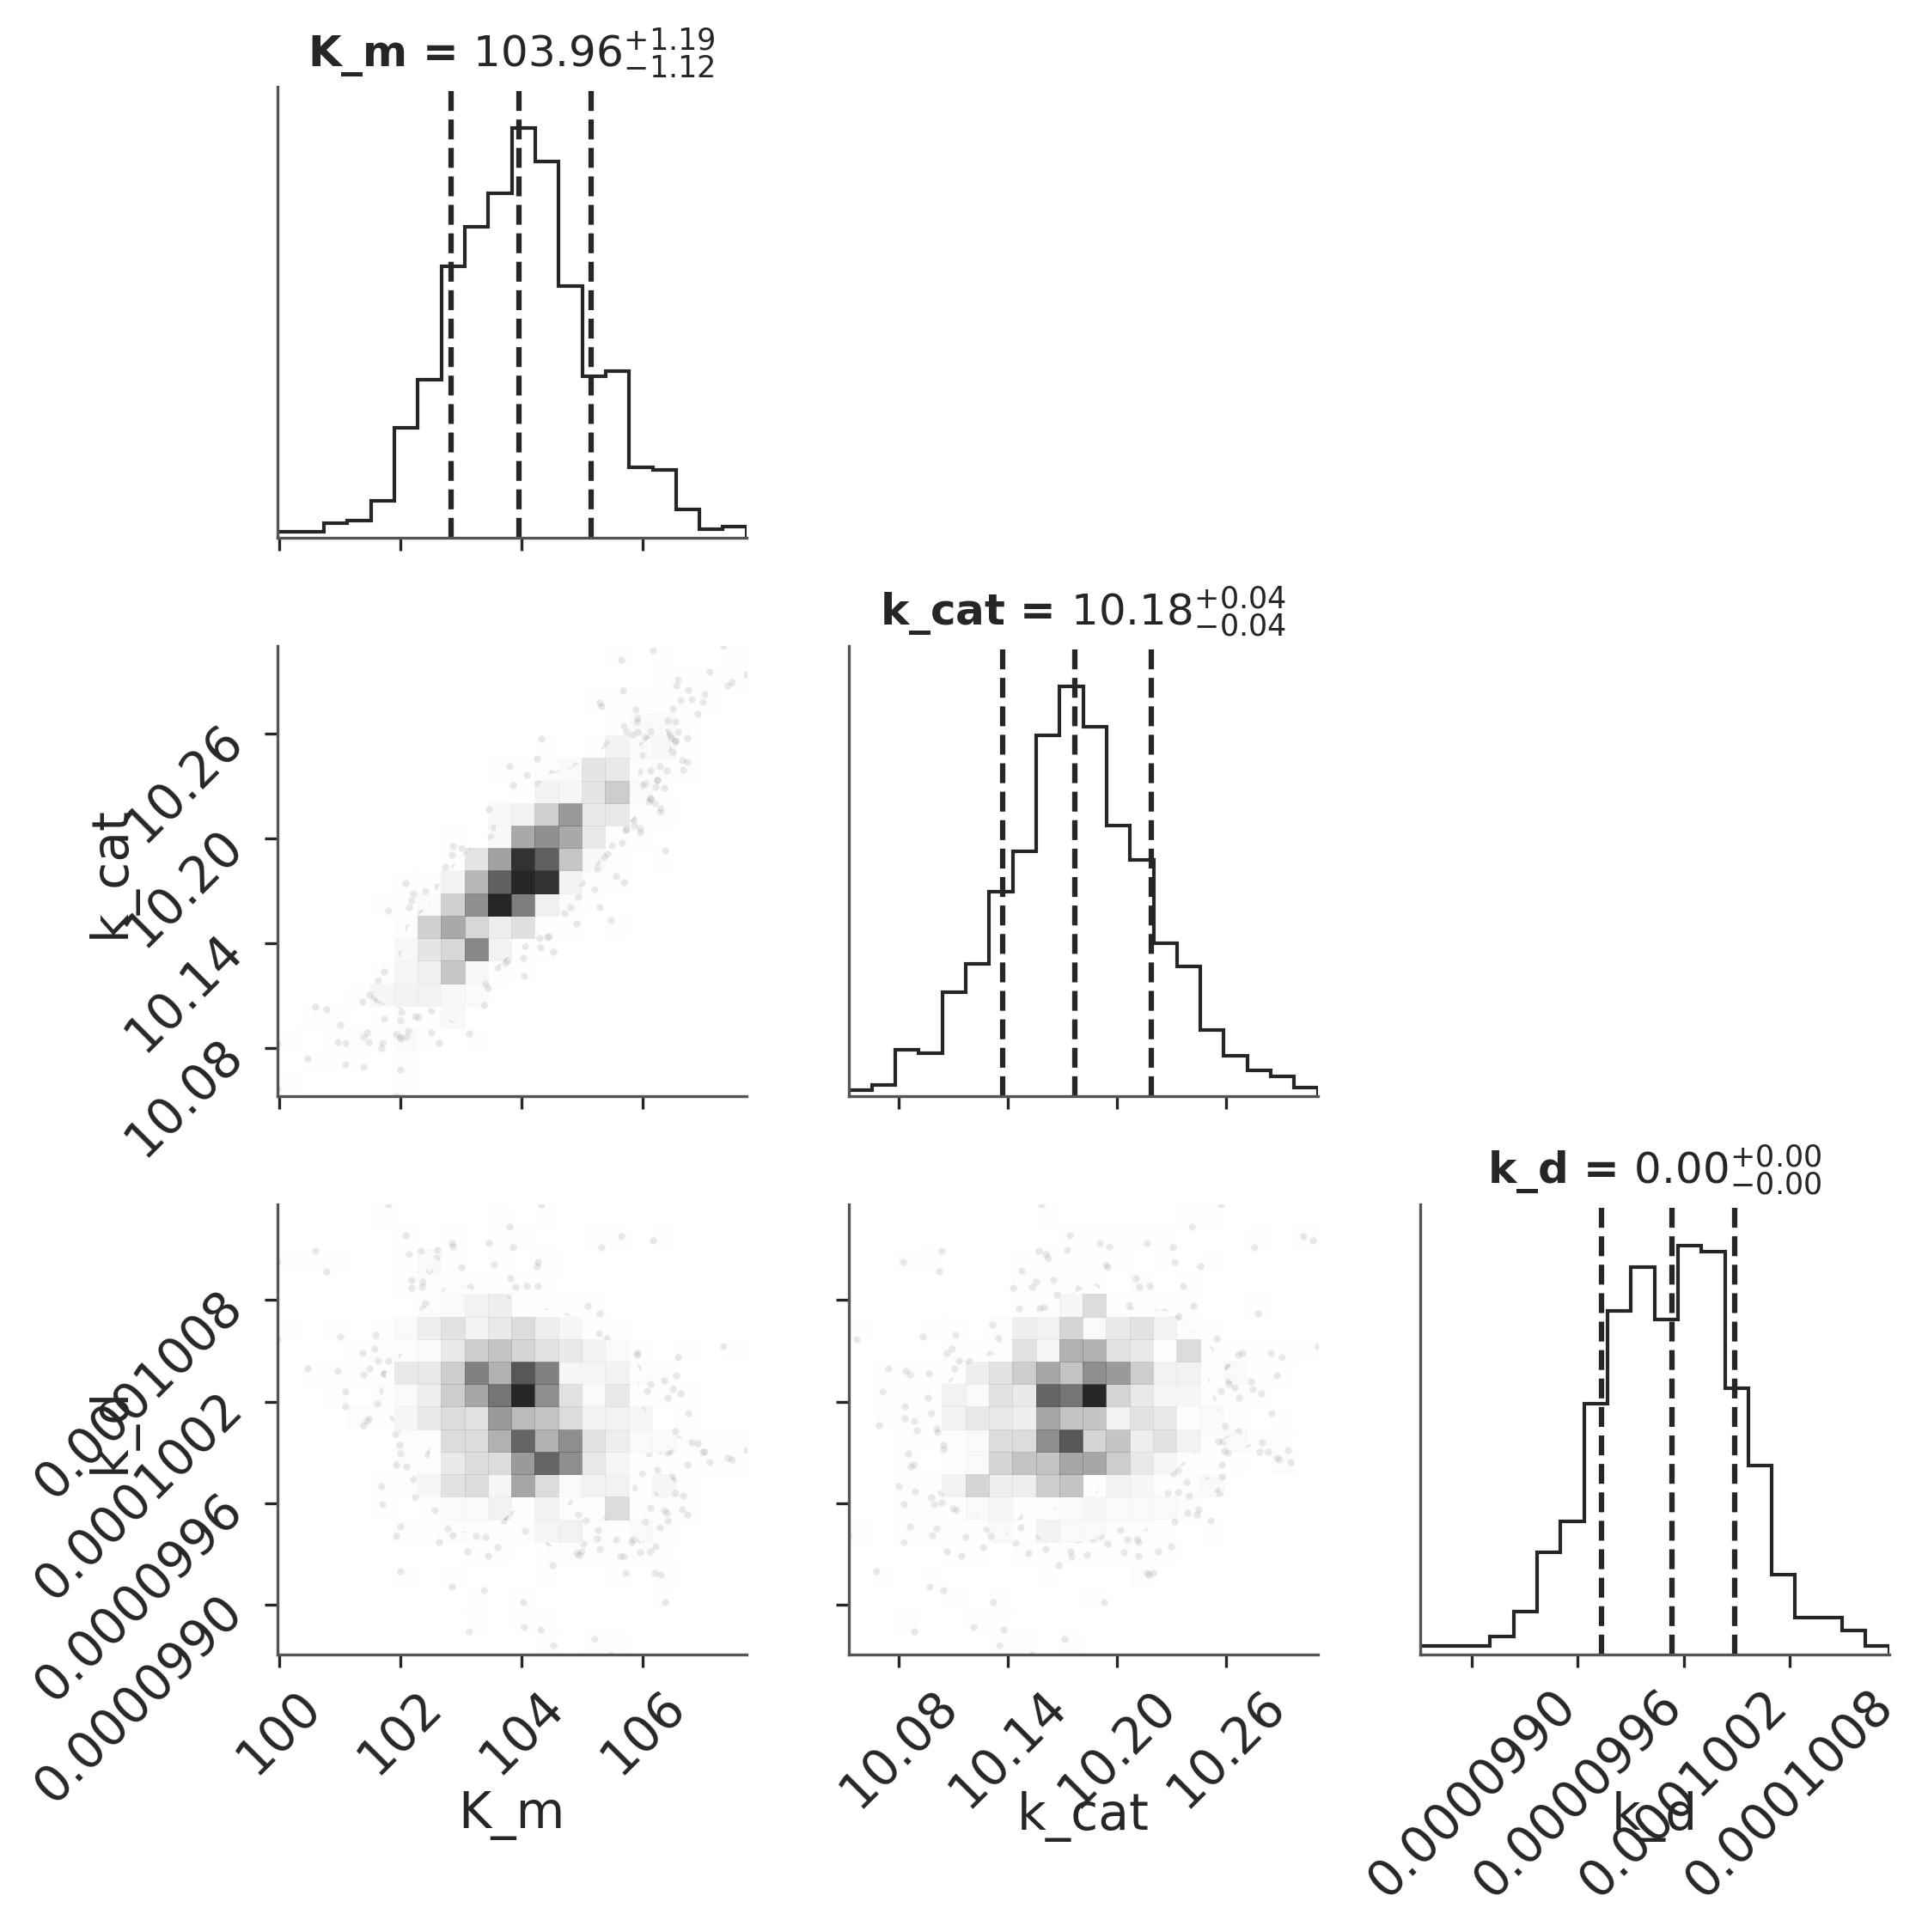

In [8]:
# Corner plot for the parameters and correlations
f = cmc.plot_corner(mcmc)